In [43]:
import pyrealsense2 as rs
import cv2
import numpy as np
from math import tan, pi
import matplotlib.pyplot as plt

In [2]:
ctx = rs.context()
devices = ctx.query_devices()

In [3]:
var = [i.get_info(rs.camera_info.serial_number) for i in devices]

In [5]:
var

['923322070538', '923322071362']

In [6]:
def get_extrinsics(src,dst):
    extrinsics = src.get_extrinsics_to(dst)
    R = np.reshape(extrinsics.rotation, [3,3]).T
    T = np.array(extrinsics.translation)
    return (R,T)

In [7]:
#returns camera matrix from intrinsics
def camera_matrix(intrinsics):
    return np.array([[intrinsics.fx, 0, intrinsics.ppx],
                     [0, intrinsics.fy, intrinsics.ppy],
                    [0,0,1]])

In [8]:
def callback(frame):
    global frame_data
    if frame.is_frameset():
        frameset = frame.as_frameset()
        f1 = frameset.as_video_frame()
        f2 = frameset.as_video_frame()
        left_data = np.asanyarray(f1.get_data())
        right_data = np.asanyarray(f2.get_data())
        ts = frameset.get_timestap()
        frame_data["left"] = left_data
        frame_data["right"] = right_data
        frame_data["timestamp"] = ts
        frame_mutex.release()

In [8]:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 90)
pipe.start(cfg, callback)

In [71]:
#depth is stored as one unsigned 16-bit integer per pixel
#distance in meters
#retrieve the depth of pixels in meters
#depth scale - units of the values inside depth frame
depth_sensor = pipe_profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
depth_scale

NameError: name 'pipe_profile' is not defined

In [9]:
dpt_frame = pipe.get_depth_frame().as_depth_frame()
pixel_dist_meters = dpt_frame.get_distance(x,y)
pixel_dist_meters

AttributeError: 'pyrealsense2.pyrealsense2.pipeline' object has no attribute 'get_depth_frame'

In [51]:
profiles.get_streams()

[<pyrealsense2.video_stream_profile: 1(0) 640x480 @ 15fps 1>,
 <pyrealsense2.video_stream_profile: 2(0) 640x480 @ 15fps 5>]

In [49]:
try:
    #retrieve stream and intrinsic properties
    profiles = pipe.get_active_profile()
    streams = {"left": profiles.get_streams()[0].as_video_stream_profile(),
              "right": profiles.get_streams()[1].as_video_stream_profile()}
    intrinsics = {"left": streams["left"].get_intrinsics(),
                 "right": streams["right"].get_intrinsics()}
    
    
    print("Left camera:", intrinsics["left"])
    print("Right camera:", intrinsics["right"])
    
    K_left = camera_matrix(intrinsics["left"])
    K_right = camera_matrix(intrinsics["right"])
    
    (R,T) = get_extrinsics(streams["left"], streams["right"])
    print("rotation matrix:", R)
    print("translation matrix:", T)

finally:
    pipe.stop()
    del pipe
    del config

Left camera: width: 640, height: 480, ppx: 316.495, ppy: 241.142, fx: 384.165, fy: 384.165, model: 4, coeffs: [0, 0, 0, 0, 0]
Right camera: width: 640, height: 480, ppx: 327.827, ppy: 245.496, fx: 607.461, fy: 606.897, model: 2, coeffs: [0, 0, 0, 0, 0]
rotation matrix: [[ 9.99991894e-01  3.35063622e-03  2.21985020e-03]
 [-3.35099758e-03  9.99994397e-01  1.59139410e-04]
 [-2.21930444e-03 -1.66576836e-04  9.99997497e-01]]
translation matrix: [ 1.50379241e-02  8.37687185e-05 -2.61208945e-04]


In [ ]:
#transform points from one coordinate space to another after knowing extrinsics
#standard affine transformation using a 3x3 rotation matrix and 3-component translation vector
rs.rs2_transform_point_to_point()

In [ ]:
#deprojection - 2D pixel location + depth and maps it to 3D point location
rs.rs2_deproject_pixel_to_point()

In [9]:
#cam1: configure depth and color streams 
pipeline1 = rs.pipeline()
config1 = rs.config()
config1.enable_device(var[0])
config1.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 90)
config1.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 60)
config1.enable_record_to_file('multicam1.bag')
print('cam1 enabled')

cam1 enabled


In [10]:
#cam1: configure depth and color streams 
pipeline2 = rs.pipeline()
config2 = rs.config()
config2.enable_device(var[1])
config2.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 90)
config2.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 60)
config2.enable_record_to_file('multicam2.bag')
print('cam2 enabled')

cam2 enabled


In [11]:
#start stream
pipeline1.start(config1)
pipeline2.start(config2)
print('cams configured')

cams configured


In [12]:
frames1 = pipeline1.wait_for_frames()
depthframe1 = frames1.get_depth_frame()
colframe1 = frames1.get_color_frame()

In [13]:
frames2 = pipeline2.wait_for_frames()
depthframe2 = frames2.get_depth_frame()
colframe2 = frames2.get_color_frame()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(480, 848)


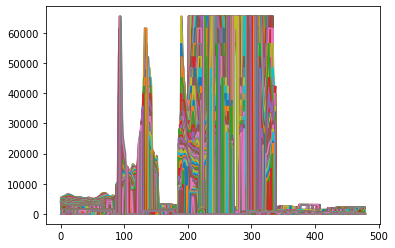

In [45]:
#get depth info for each pixel from cam1
depth_data = depthframe1.as_frame().get_data()
np.image = np.asanyarray(depth_data)
print(np.image)
print(np.image.shape)
plt.plot(np.image)
plt.show()

In [37]:
#get depth info for each pixel from cam2
depth_data2 = depthframe2.as_frame().get_data()
np.image2 = np.asanyarray(depth_data2)
print(np.image2)

[[   0    0    0 ...    0    0    0]
 [   0    0    0 ... 1033 1031    0]
 [   0    0    0 ... 1033 1033    0]
 ...
 [   0    0    0 ...  434    0    0]
 [   0    0    0 ...  434    0    0]
 [   0    0    0 ...    0    0    0]]


In [38]:
sum(np.image2)

array([    0,     0,     0, 45587, 14762, 29226,  8269,  8960,  7172,
       24550, 26317,  1503, 21277, 27053, 43745, 45045, 39472, 43748,
        1553, 12305,  9326,  7519, 11677,  5041, 45555, 15753, 13386,
       59968, 40347, 12338, 28484, 34711, 35428, 49678, 49794, 32648,
       41481, 32260, 21096, 16936, 11875,  2639,  3800, 64677,  1548,
       52431, 51314, 29451, 16078, 38315, 48920, 39719,  5107, 61360,
        3251,   638, 14063, 21040, 26916, 30715, 25535, 36861, 45195,
       53370, 40471, 33180, 33860, 21005, 23080, 48735, 38897, 45655,
       37883, 26631, 55173, 42127, 23818, 26575, 29831, 58410, 15227,
        5846,  5258, 43832, 20934, 27802, 65210, 38826, 16661, 61441,
       30446, 23673, 15170, 41181, 26957,  4683, 54019,  7819,  3136,
        3639,  9407, 18850, 64464, 59518,  5452,  7275, 14254, 40576,
       60381, 21238, 41288,   343, 12862, 25974, 15340, 15631,  8779,
       63585, 59101, 21120, 10987, 46837, 49360, 19195, 38828,  4422,
       43751, 34224,

In [30]:
print(sum(np.image).shape)
sum(np.image)

(848,)


array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0, 58893, 56775, 13020, 51037, 52140,  8750, 30627,
        6803,  7299,  8516, 23184,  7702, 47258,  9802, 18336,  7335,
       11924, 30451, 20760, 46885, 33106, 38549,  3895, 14020, 17822,
        5686,  9429, 31014, 34034, 36563, 57025, 16232, 23133, 31858,
       62154,  2308, 60328, 61496, 60955, 60647, 57027, 56448, 59087,
       52056, 62562, 53918, 49998, 45688, 39481, 34151, 26110, 27725,
       32868, 30885, 21473, 24259,  8216, 22129, 35369, 49318, 33875,
       35484, 34805, 43321, 30514, 25237, 28442, 59882, 57706, 45117,
       43678, 34109, 34054, 35181, 35923, 37592, 50678, 60192,  1350,
       18270, 16827, 11874, 26522, 28069, 37609, 38240, 41112, 51941,
       60317,  3271, 55844,  2114, 59034, 50687, 43365, 29895, 34567,
       40238, 27014, 64170, 49371, 55074, 56525, 49497, 44244, 39154,
       38188, 38353,  5114,  2779,   971, 13616, 13667, 16596, 20446,
       15571, 14241,

In [35]:
sum(np.image.T)

array([43489, 34864, 52061,  5073, 19309, 29730, 31862, 26523, 41233,
       52966, 11353,  9394, 11263, 11188, 60663, 65100, 11994, 18066,
       11783, 26182, 30073, 34889, 43948, 39569, 40586, 41640, 33155,
       34808, 30054, 23672, 21659, 21262, 17329, 21398, 21645, 25470,
       27741, 31368, 26434, 38501, 34957, 39400, 38238, 39188, 42206,
       44805, 34816, 28906, 21171, 22532, 28361, 27750, 27480, 36543,
       36059, 32258, 35037, 32594, 32744, 34906, 26015, 20672, 21319,
       24809, 31074, 32699, 31657, 37674, 40547, 34959, 33077, 39809,
       46429, 35331, 47696, 29513, 13693, 20159, 12362, 13889, 16288,
       60220, 60983, 40305, 24994,  4409,  8035, 21780, 57564, 62161,
        1771, 40475, 29010, 58976, 25190,  8109, 64493, 63444,  1299,
       31546, 13636,  4734, 57966,  2051, 10049, 58549,  1572,  9175,
        2075, 63579, 17911, 55968, 56649, 47136, 31082, 37089,  8157,
       34303, 12570, 57251,  8661, 20792, 19540, 43824, 54148, 45805,
       57027, 39082,

In [96]:
#extrinsics from color frame to depth frame
depth_intrin = depthframe1.profile.as_video_stream_profile().intrinsics
color_intrin = colframe1.profile.as_video_stream_profile().intrinsics
d_to_c_extrin = depthframe1.profile.get_extrinsics_to(colframe1.profile)
d_to_c_extrin

rotation: [0.999975, 0.00664581, -0.00249566, -0.0066471, 0.999978, -0.000507153, 0.00249223, 0.000523729, 0.999997]
translation: [0.0149223, 0.000452507, -0.000142553]

In [102]:
depthframe1.profile.get_extrinsics_to(depthframe1.profile)

rotation: [1, 0, 0, 0, 1, 0, 0, 0, 1]
translation: [0, 0, 0]

In [60]:
#depth is stored as one unsigned 16-bit integer per pixel
#distance in meters
#retrieve the depth of pixels in meters
#depth scale - units of the values inside depth frame
depth_sensor = pipe_profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
depth_scale

NameError: name 'pipe_profile' is not defined

In [8]:
#map depth to color
depth_pixel = [240,320] #random point
depth_point = rs.rs2_deproject_pixel_to_point(depth_intrin, depth_pixel, depth_scale)
color_point = rs.rs2_transform_point_to_point(depth_to_color_extrin, depth_point)
color_pixel = rs.rs2_project_point_to_pixel(color_intrin, color_point)
pipeline.stop()

In [9]:
print(depth_point)
print(color_point)
print(color_pixel)

[-0.0006133948918431997, -7.135550549719483e-05, 0.0010000000474974513]
[0.014311893843114376, 0.0003776001394726336, 0.0008590113138779998]
[10583.90625, 507.1816711425781]


In [ ]:
cv2.calibrateCamera